Video: https://www.youtube.com/watch?v=bCz4OMemCcA

## Tokens
A token is an individual unit of data. In NLP, a token often represents a word, but it can also represent smaller units like subwords, characters.

## Tokenisation
This is the process of converting text into tokens. For example, the sentence `"Hello, world!"` might be tokenized into `["Hello", ",", "world", "!"]`.

# RNN

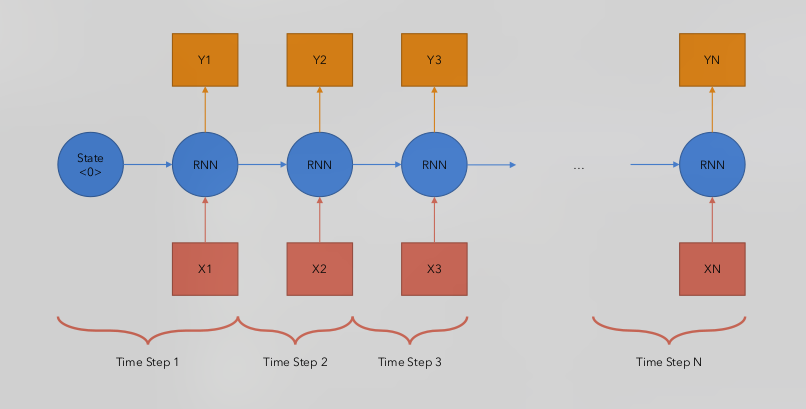


* In a RNN, the tokens are processed sequentially, one at a time. Thus, longer computation time for long sequences. 
* RNNs are known for vanishing and exploding gradients.
* The hidden state is updated for each set ok token. As we move to the last set of tokens, the hidden state is forgets whatever it learned from the first set of tokens.
* Doesn't need positional encoding, because tokens are processed one by one, so the positional information is already known.

# Transformers
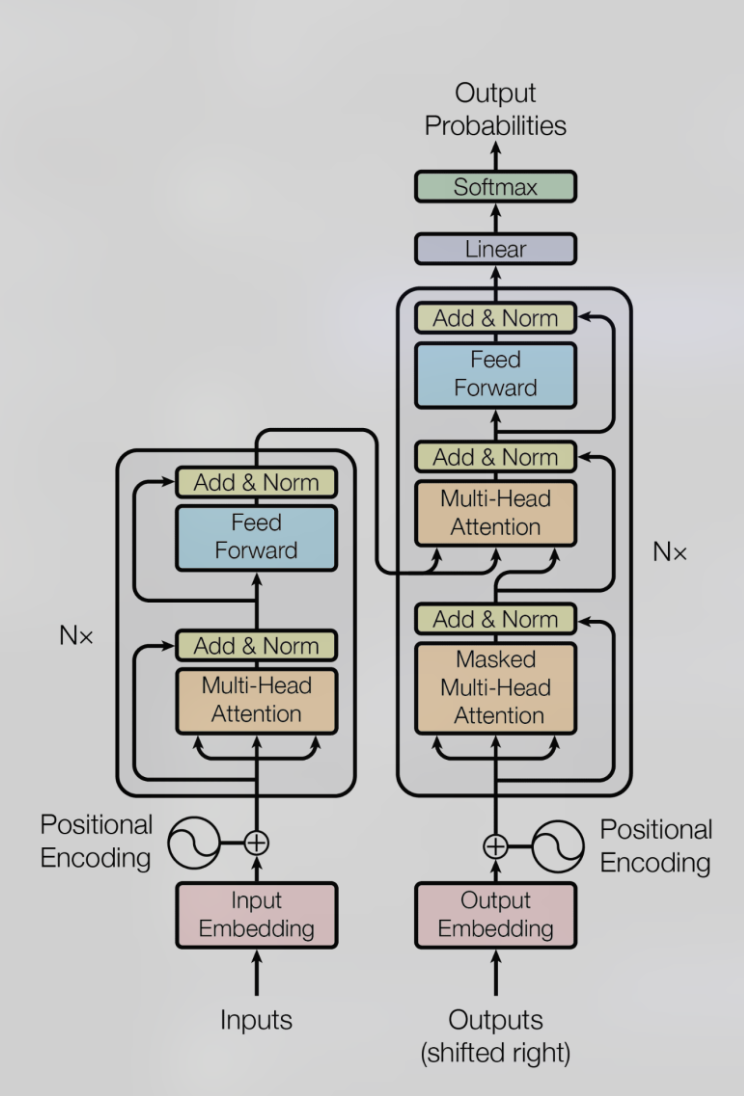

There are two block, the first block, one the left, is called the encoder and the second one, on the right, is called the decoder. The information from the encoder is shared with the decoder with a arrow marked in the diagram. Unlike LSTM, RNN all the tokens are passed in one go and we need a way to incorporate sequence order information.

## Notations
* Input matrix (sequence, $d_{matrix}$)

while we apply different embeddings the dimension will remain the same.


## Encoder
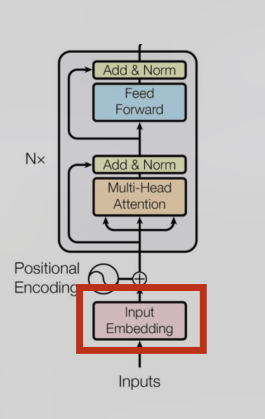

The first step is the input embedding.
### Input embedding


The first step is to learn the meaning of each word. The following steps allows us to learn the mearning of each word.
* We divide the sentence into words, and each words is a token.

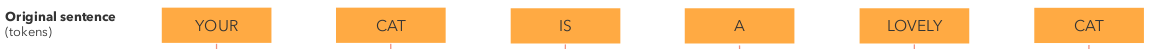
* We map these words into numbers (input IDs). These number denotes the position of our word in a big volcabulary. This vocabulary contains all the possible words in our training dataset.

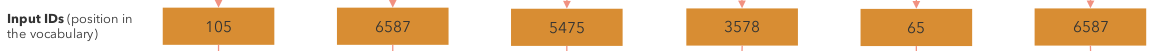
* Map the input IDs into a vector called the embedding. Each word will have its own vector. These embeddings are learned during training for each word. As a result, these vectors learn the meaning of the words. The size of the embedding vector is called $d_model$.

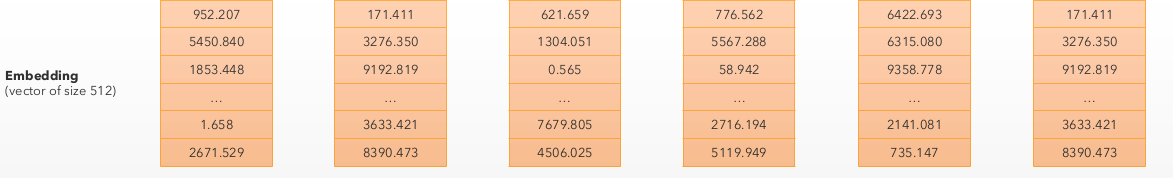
Once can see that the second and last words are same, thus the input IDs and embedding vector is same for them.

### Positional encoding
Now that we know the meaning of each words in our training dataset using the input embedding. We need to create a positional encoding so that our model can understand the meaning of the words in the context of each other. For example, in "your cat is a lovely cat", the word "lovely" is more useful than "is" and "a" in the context of "cat". This will help the model to learn the pattern from the sentences.

* Following are the input embeddings that we obtained earlier.

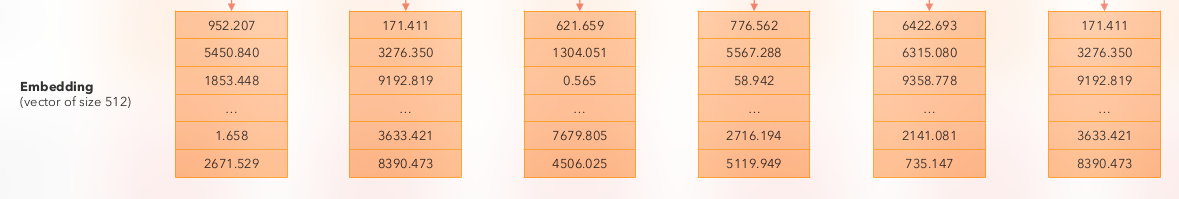

Now, another add vector of same size (obviously). This vector is called the position embedding and is not learned, but once computed and reused for each sentence during the training and inference.

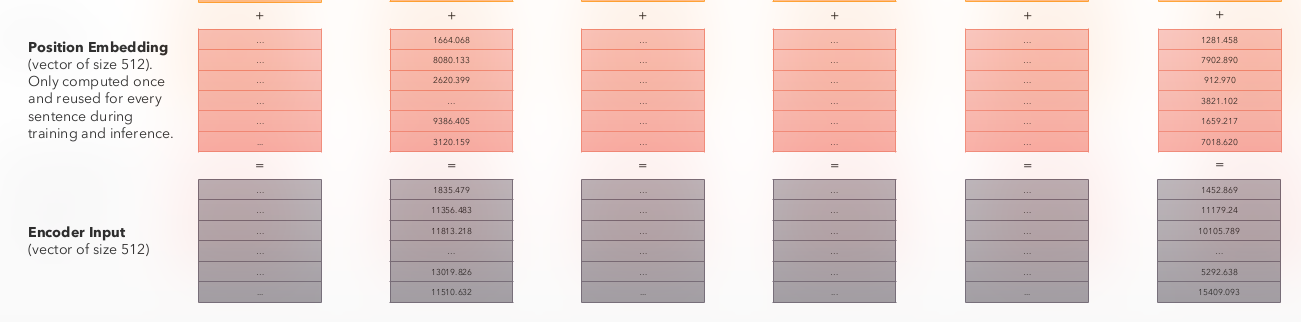

Finally, we will end up with a vector which serves as the input of the encoder.

Now the question is, how we calculate these positional encoding/ embedding. We use two forumulae.
$$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$
$$PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

* $PE$ stands for positional encoding, 
* $pos$ is the position of the token in the sequence. 
* $d_{\text{model}}$ is the dimension of the embedding, predecided.
* $i$ is the index within the embedding vector.

* **For even indices (0, 2, 4, ...), the sine function is used.**

* **For odd indices (1, 3, 5, ...), the cosine function is used.**

* **We only need to compute the positional encodings once and then reuse them for every sentence, no matter if it is training or inference. So, calculate this at the start of the training.**

Here is a simple example,

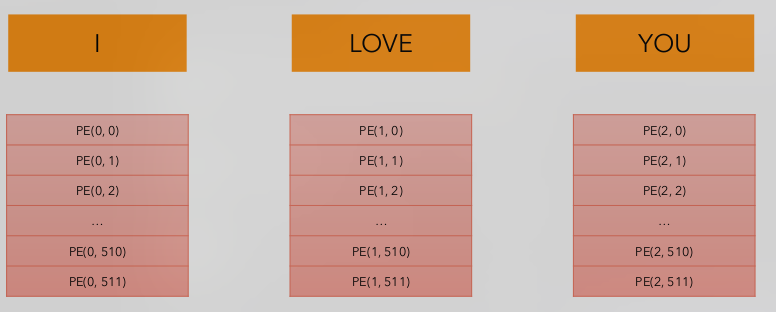

Naturally the range of the function is limited to $[-1, 1]$.

Now the question out of all the mathematics we know, why use sine and cosine functions?

The formula uses a different frequency of the sine and cosine functions for each dimension of the positional encoding vector. This is because the positional encoding vector is a function of the position of the token in the sequence. The denominator is just a scaling factor. This creates a gradient of wavelengths for the sine and cosine functions, which helps the model learn to distinguish different positions in the sequence.

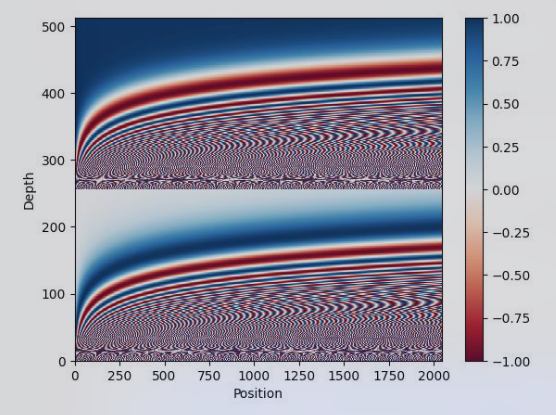

* Notice that the wavelengths (the distance between peaks of the waves) change across the depth. At the top of the image (lower dimensions), the wavelengths are longer, which means that the encoding changes more slowly with respect to the token position. As you move down (toward higher dimensions), the wavelengths become shorter, so the encoding changes more rapidly.
* In details, at depth 0, the frequency of the wave is the highest, which means the wave completes many oscillations over the sequence length. 
* Beyond a certain depth (around 100), the frequency becomes so low that the wave doesn't complete even one full oscillation across the sequence length. This part of the positional encoding provides very slow-changing positional information, which can help the model understand very long-term dependencies in the sequence.
*  **The lower frequencies provide global position information (useful for understanding the overall structure of the sequence), while the higher frequencies provide local position information (useful for understanding fine-grained details and relationships between tokens that are close together).**

* **This is important because, unlike RNNs and LSTMs which process sequences step-by-step and inherently understand the order of tokens due to their architecture, transformers process all tokens simultaneously and need a way to incorporate sequence order information.**

### Self-attention / single head attention
Now that we know the meaning of each words and its local and global position with the position embedding. We can now start to understand the relationship between different words in the sentence. Self attention is an old technique to enable the model understand the relationship between different words of the sentence.

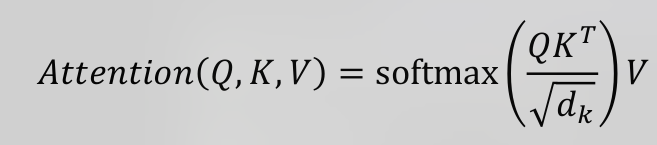

we will understand the meaning of this formula later. For now they are called the query, key and value.

Say the length of the sequence is $n = seq = 6$ and $d_{model} = d_k = 512$. The softmax part of the formula can be calculated as:

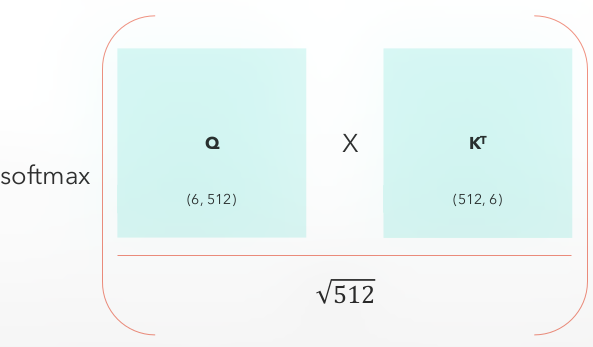

Here, you can see that the final size is a square matrix of dimension equal to the length of the sequence $d_k$. Also, the sum of the elements in the matrix is equal to 1 because of the softmax. This results looks similar to a confusion matrix. That is a score telling the relative importance of two tokens.

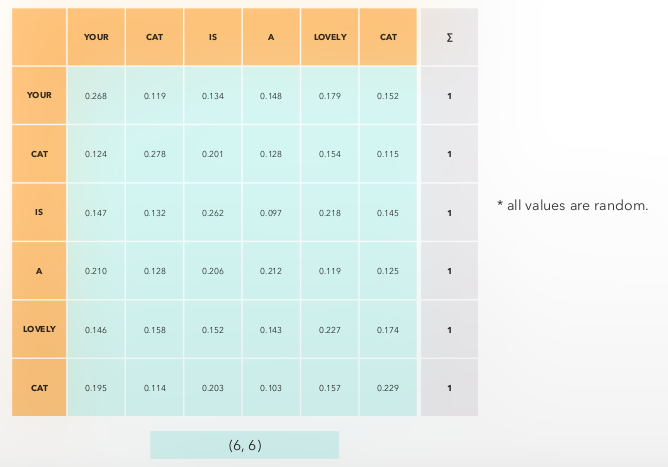

The final multiplication looks like this. Notice the dimension remains the same.

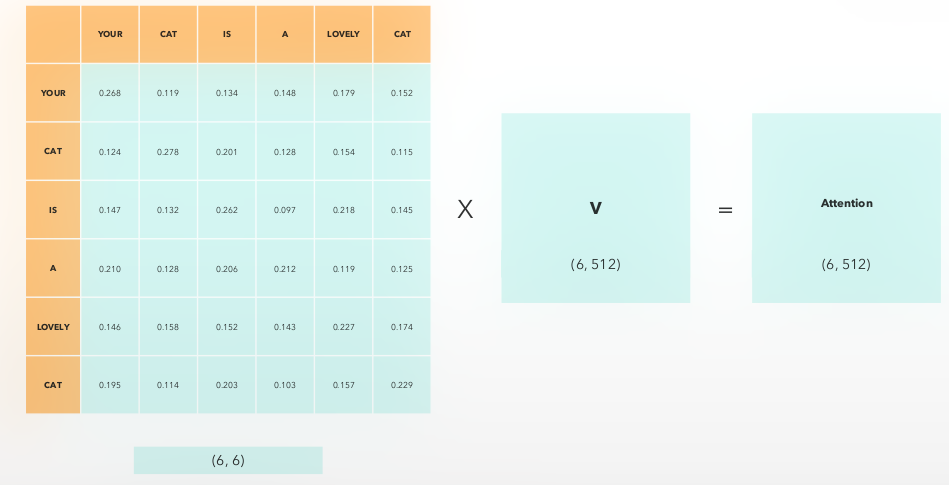

Each row in this matrix captures not only the meaning (given by the embedding) or the position in the sentence (represented by the positional encodings) but also each word’s interaction with other words.

* Self-attention is permutation invariant.
If you change the order of the input tokens, the output of the self-attention layer remains the same, which is not typically desirable in natural language processing tasks. The context and meaning of a sentence in a language like English are heavily dependent on the order of the words (tokens). **That is why we need positinal encoding. This way, even if two sentences have the same words but in different orders, their positional encodings will be different, leading to different outputs from the self-attention layers. Essentially, positional encodings break the permutation invariance of the self-attention mechanism.**

* No training parameters are required in self attention.
* Due to the confusion matrix nature of the softmax term the diagonal elements have the highest value.
* If we don't want two tokens to be able to see each other, we can set the diagonal elements to $-\infty$. The softmax will replace this with 0. This is used in decoder.

# Multi-head attention
* `seq` = length of the sequence
* $d_{model}$ = dimension of the embedding
* h = number of attention heads
* $d_k= d_y$ = $d_{model}/h$

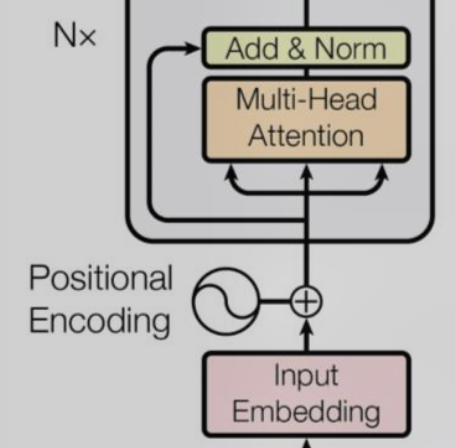

Here we take 4 copies of the output from the positional encoding one is sent to the `Add & Norm` layer and three are sent to the multi-head attention layer. So the value of Q, K, V is basically same because they are copies of the positional encoding. So, they have the same size.

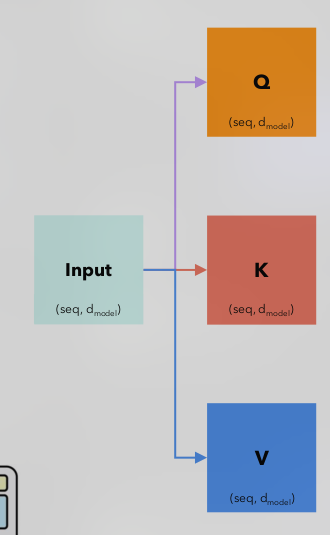

we then multiply these Q, K, V with three weight matrices viz, $W^Q, W^K, W^V$ with shapes such that the multiplication is compatible. We obtain the following shapes.$Q', K', V'$ matrices.

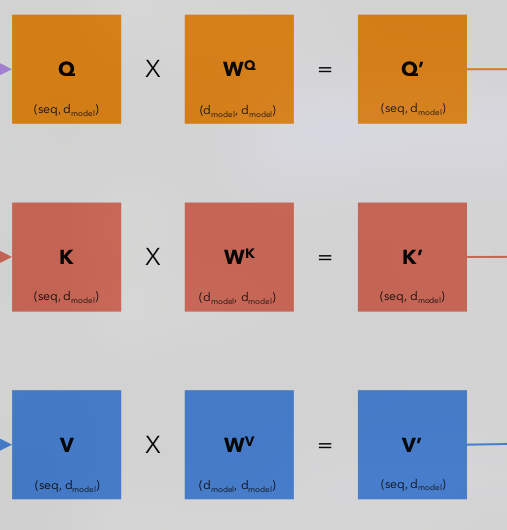

Next, we split these matrices into smaller matrices. In multi-head attention, we split by $d_{model}$, so every head will see the full sequence but a smaller part of embedding of each word. Mathematically, if number of heads is $h$, the size of the embedding vector is $d_{model}$, then each head will see $d_k = d_{model}/h$ entries of the embedding vector, which is fraction of the embedding vector.

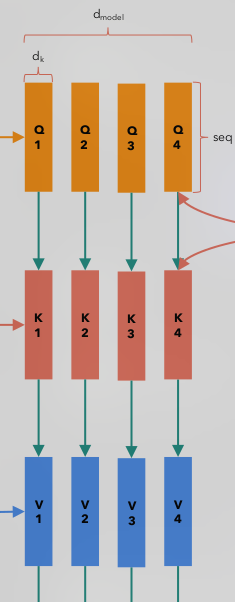

We can now calculate the attention for each head.

$head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$

This will result in head matrices $head_1, head_2, head_3$ and so on.

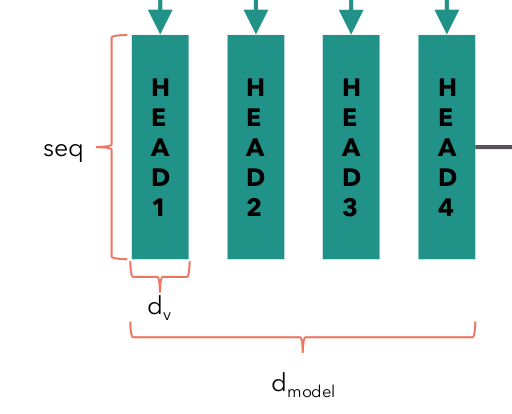

Then we concatenate these matrices to get the final matrix $H$.

$$ Multihead(Q, K, V) = Concat(head_1, head_2, head_3, ...) W^0 = H \times W^0$$

Here is the shape of each component.

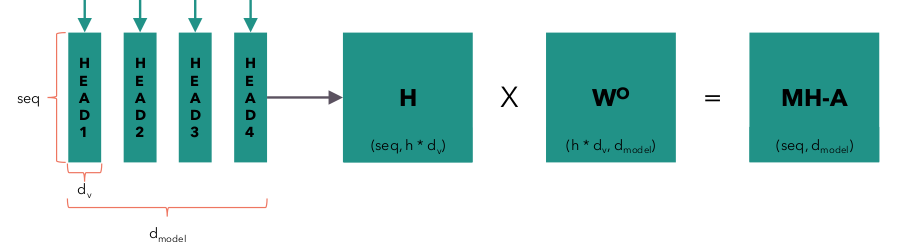

One can visualize the multi-head attention by plotting the following:

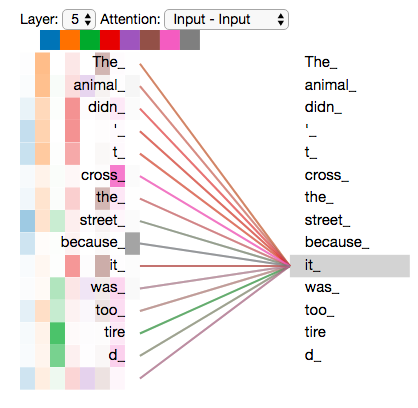

# Why Q, K, V?
The intuition came from pythonic dictionaries. Imagine we have a dictionary of movie Genre and the corresponding movies. We can query the dictionary with the genre and get the movies. This is the intuition behind the Q, K, V.

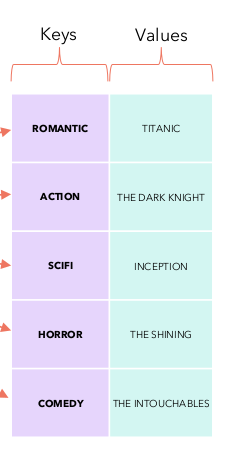

If the Query is "Love", and in transformers all the words are represented as embedding vectors. So, we can calculate the similarity between the query and the keys. The similarity can be calculated using dot product. The dot product is high if the vectors are similar and low if they are not. The similarity is then scaled by the square root of the dimension of the embedding vector. This is done to avoid the gradient explosion. The softmax is then applied to get the attention weights. The attention weights are then multiplied with the values to get the output. 

So, we might end up with "romantic" as the closest match. and "action", "scifi" and "horror" with the lowest score.

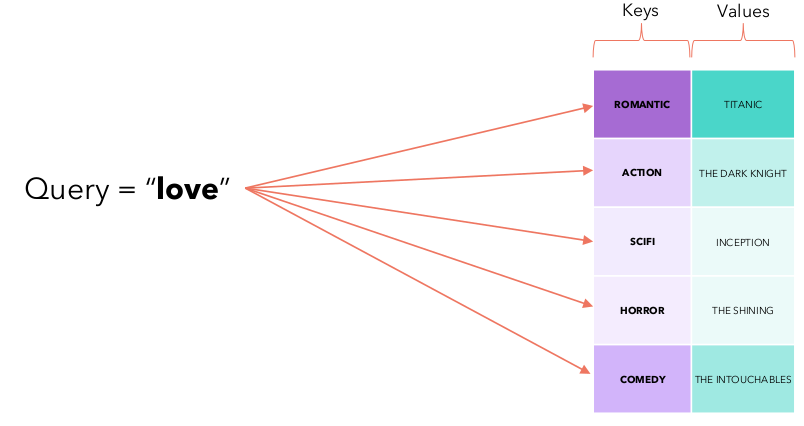

## Add and Norm

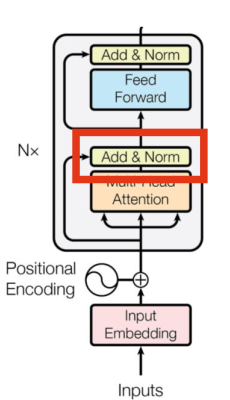

### Layer normalization

Imagine we have a batch of $N$ items. The distribution of the items are different i.e., the mean and standard deviation is different. We want to normalize the distribution of the items such that the new values are in range between 0 and 1. We can do this by subtracting the mean and dividing by the standard deviation. This is called the layer normalization.
mean and standard deviation is 

$$\mu = \frac{1}{N}\sum_{i=1}^{N}x_i$$
$$\sigma = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \mu)^2}$$
$$x_{norm} = \frac{x - \mu}{\sigma}$$

If the standard deviation is close to zero, then the denominator will be close to zero and the value will be close to infinity. This causes numerical stability issues. To avoid this, we add a small number $\epsilon$ to the denominator.

Thus we use a modified form as follows:

$$x_{norm} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$$


# Decoder

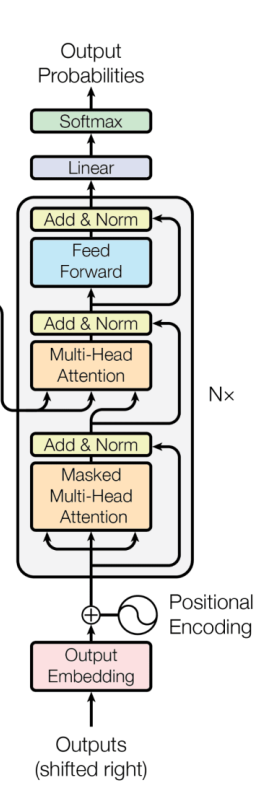

The output from the Encoder is used as the keys and values but the query is the output os the previous layer in the decoder.

# Masked multi-head attention
The goal is the make the model causal. That is, the model should not be able to see the future tokens. This is done by masking the future tokens. This is done by setting the diagonal elements of the attention matrix to $-\infty$.

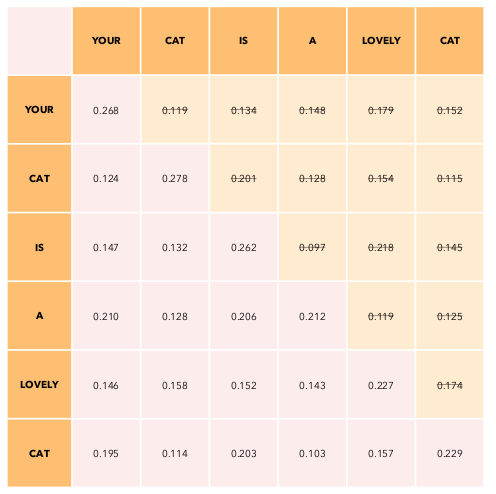

Here we don't want "your" token to be able to see "cat" and all later tokens. So, we set the diagonal elements to $-\infty$ before applying softmax. This will result in the softmax replacing the $-\infty$ with 0. Thus, the attention matrix will be zero for the future tokens.

# Training
We do a simple training from "I love you so much" to "Ti amo molto" which is the Italian translation of the same sentence. We defined two special tokens, `<sos>` and `<eos>` which denotes the start and end of the sentence.

So our input is `<sos> I love you so much`. We use the cross entropy loss to calculate the loss. The loss is then backpropagated to update the weights.

## Training step 1
The Encoder obtains the full sentence. The encoder outputs, for each word a vector that not only captures its meaning or the position in the sentence but also its interaction with other words by means of multi-head attention.

We prepend the `<SOS>` token at the beginning of the decoder which serves as the Query. That is why the output (shifted right) is written in the official image. The label which is used to calculate the loss is left shifted `Ti amo molto <EOS>`. The decoder outputs a IDs for each word from the vocabulary. We can pass both these predicted and label to the loss function to calculate the cross entropy loss.

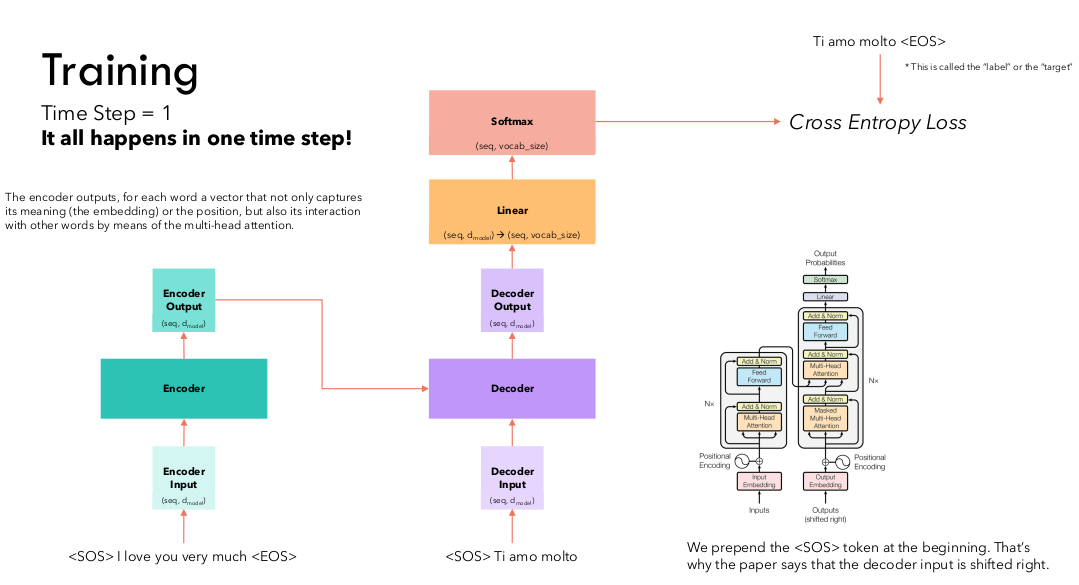

### Why we need `<SOS>` and `<EOS>` tokens? 

We need to tell the model when to start and stop. 

## Inference
When the input to the decoder is
* `<SOS>` the output should be `Ti`
* `<SOS> Ti` the output should be `amo`
* `<SOS> Ti amo` the output should be `molto`
* `<SOS> Ti amo molto` the output should be `<EOS>`

When the output token is `<EOS>` we stop the inference because the translation is done. So, we don't need a training loop. All the tokens are passed in one go unlike RNN and LSTM.

### Inference strategy
* We don't need to compute the encoder output again and again for inference. We can compute it once and reuse it for all the tokens.
* **autoregressive generation** : The output token is then appended to the sequence of previously generated tokens. This growing sequence serves as the context for the next prediction. In sequence to sequence learning, this approach is often referred to as autoregressive generation, means that the generation of each new token conditions on the history of previously generated tokens. It's important to note that during inference in autoregressive models, the predictions are made one token at a time
* **Greedy search** : The output of the softmax of the decoder has the probability of each token in the vocabulary. We can select the token with the highest probability. This is called greedy search. This is not the best approach because it might not be the best translation.
* **Beam search** : We can select the top k tokens with the highest probability and evaluate all possible next tokens for each of them. This is called beam search. This is better than greedy search but it is computationally expensive.

### Padding
Although we did not cover this the example, the padding is almost always necessary in sequence to sequence learning. The input and output sequence should be of same length. So, we pad the input and output sequence with `<PAD>` token. The loss is calculated only for the non padded tokens.